# Camera analysis by user precise

In [25]:
from scipy.stats import friedmanchisquare
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import probplot

conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryData = """SELECT
               *,
               avg (((0.1 - DistanceFinished) / CameraDistance)) AS Performance
               FROM DistancesPerTestCasePrecise
               GROUP BY ScenarioCase, UserID"""
observed_group = "UserID"
tested_variable = 'Performance'

Data = pd.read_sql_query(queryData, conn)
DataAverageAggregated = Data.groupby([observed_group, 'ScenarioCase'])[['CameraDistance', 'DistanceFinished', 'Performance']].mean().reset_index()

    ScenarioCase  count      mean       std       min       25%       50%  \
0         FOLDAR   12.0  0.540048  0.320199  0.192757  0.355293  0.442508   
1     FOLDAROPEN   12.0  0.288511  0.238199  0.016389  0.115304  0.222036   
2  STATEOFTHEART   12.0  0.519250  0.484460  0.055937  0.104700  0.374886   

        75%       max  CameraDistance  
0  0.628427  1.325868        1.768686  
1  0.429301  0.683619        3.615036  
2  0.707641  1.501116        1.862470  


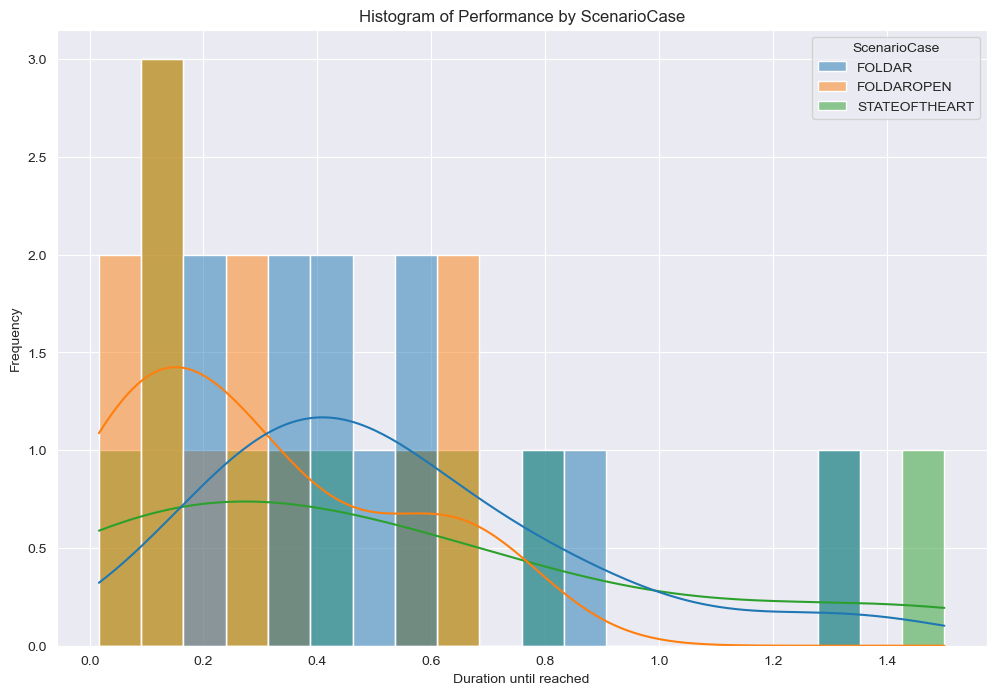

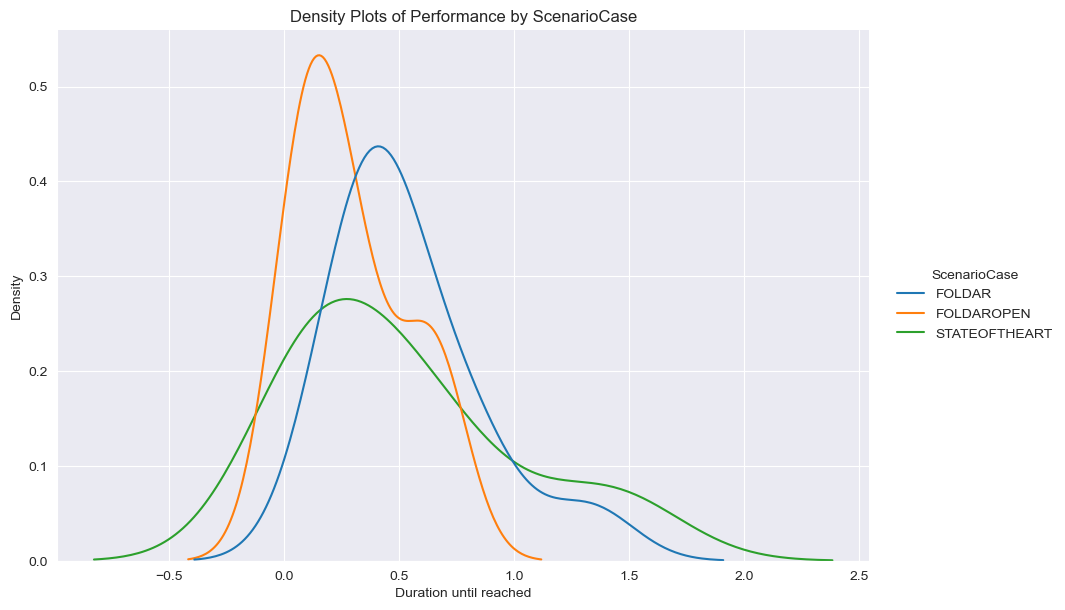

In [26]:
#Average duration for each scenario
summary_stats = DataAverageAggregated.groupby('ScenarioCase')[tested_variable].describe()
DataUserScenario = DataAverageAggregated.groupby('ScenarioCase')[["CameraDistance"]].mean().reset_index()
# Falls summary_stats den Index "ScenarioCase" hat,
# setze bei DataUserScenario "ScenarioCase" als Schlüssel.
combined_output = pd.merge(
    summary_stats.reset_index(),  # falls summary_stats als Index ScenarioCase hat
    DataUserScenario,
    on='ScenarioCase',
    how='outer'
)
print(combined_output)

plt.figure(figsize=(12, 8))
sns.histplot(data=DataAverageAggregated, x=tested_variable, hue="ScenarioCase", kde=True, bins=20, alpha=0.5)
plt.title('Histogram of Performance by ScenarioCase')
plt.xlabel("Duration until reached")
plt.ylabel("Frequency")
plt.show()

sns.displot(data=DataAverageAggregated, x=tested_variable, hue='ScenarioCase', kind="kde", height=6, aspect=1.5)
plt.title("Density Plots of Performance by ScenarioCase")
plt.xlabel("Duration until reached")
plt.ylabel("Density")
plt.show()

# Check for normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.869395 | p-value: 0.064206
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.874627 | p-value: 0.074830
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.857345 | p-value: 0.045290


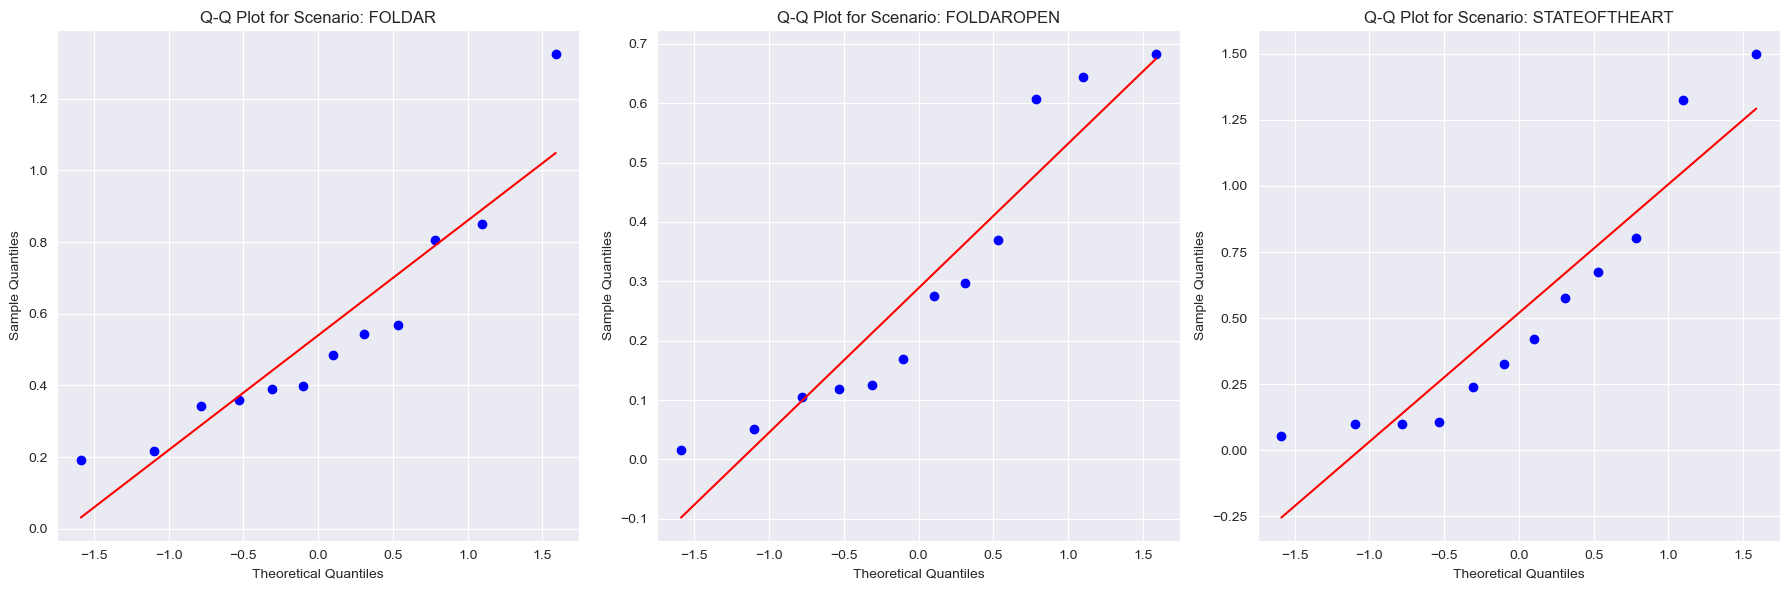

In [27]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataAverageAggregated['ScenarioCase'].unique():
    data_scenario = DataAverageAggregated.loc[DataAverageAggregated['ScenarioCase'] == scenario, 'Performance']
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.6f} | p-value: {p_value:.6f}")

# Get unique scenarios
scenarios = DataAverageAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataAverageAggregated.loc[DataAverageAggregated['ScenarioCase'] == scenario, 'Performance']
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

# Friedman Test

Friedman Test Statistic: 5.166666666666657
p-value: 0.07552184450877414
No significant differences found.


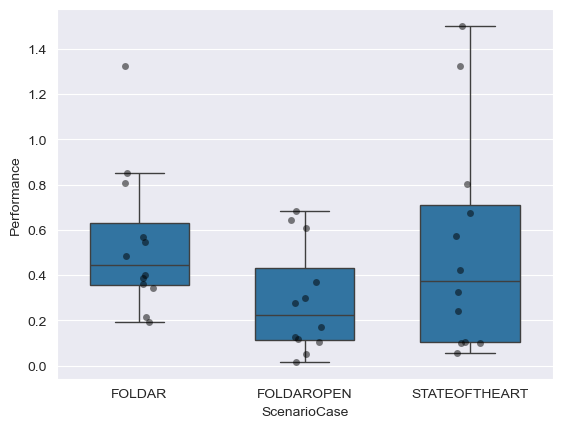

In [28]:
scenario_data = [DataAverageAggregated[DataAverageAggregated['ScenarioCase'] == case][tested_variable].values
                 for case in DataAverageAggregated['ScenarioCase'].unique()]

stat, p_value = friedmanchisquare(*scenario_data)

print(f"Friedman Test Statistic: {stat}")
print(f"p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant differences exist between the groups (ScenarioCase).")
else:
    print("No significant differences found.")

sns.boxplot(data=DataAverageAggregated, x='ScenarioCase', y=tested_variable, width=0.6, showfliers=False)
sns.stripplot(data=DataAverageAggregated, x='ScenarioCase', y=tested_variable, color='black', alpha=0.5)
plt.show()